In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import signal
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from loess.loess_1d import loess_1d
from statsmodels.nonparametric.smoothers_lowess import lowess
# from tvregdiff import TVRegDiff
import pandas as pd
from scipy.optimize import curve_fit

In [29]:
def create_exp(N, A, B):
    expo = A*np.exp(-B*np.arange(0,N))
    return expo
def create_lin(N, a, b):
    lin = a*np.arange(0,N) + b
    return lin
def concat_noise(C, m = 0, s = 1):
    # import numpy as np
    concat = []
    for c in C:
        concat.extend(c)
    X = np.arange(0,len(concat))
    Y = concat +  np.random.normal(loc=m, scale=s, size=len(concat))
    return X, Y

def RMSE(Ypred, Yreal):
    rmse = np.sqrt(np.sum(np.square(Ypred-Yreal))/np.shape(Ypred)[0])
    return rmse
def fit_and_pred(X, y):
    Xarr = np.array(X).reshape(-1,1)
    yarr = np.array(y).reshape(-1,1)
    
    sample_weight = np.ones(yarr.size)
    print('sample weight raw\n', sample_weight)
    print('phase lin')
    sample_weight = np.arange(1,yarr.size+1) 
    sample_weight = np.square(sample_weight)
    sample_weight = sample_weight / sample_weight.max()
#     sample_weight = np.flip(sample_weight)
    print('sample weight weighted\n', sample_weight)
   
    reg = LinearRegression().fit(Xarr, yarr, sample_weight)
    pred = reg.predict(Xarr)
    rmse = RMSE(pred, yarr)
    return rmse


def sliding_window_pred(X, y, window, lag):
    Xend = np.shape(X)[0]
    Xmax = np.shape(X)[0]-lag-1
    start = np.arange(window, Xend-window, lag)
   
    mean_start = X[[int(Xend-s) for s in start]]
    # print('lin idx', [int(np.floor((Xend-s+ Xend)/2)) for s in start])
    # print('mean start LIN',mean_start)
    # input()
    score = [fit_and_pred(X[Xend-s:Xend], y[Xend-s:Xend]) 
            for s in start]
    score = min_max(score)
    
    return score, mean_start

# def func(x, a, b):
#     return a * np.exp(-b * x) + c
def func(x, a, b):
    return a * np.exp(-b * x) 

def fit_and_pred_exp(X, y, b, p=False):
    Xarr = np.array(X).reshape(-1,1)
    yarr = np.array(y).reshape(-1,1)
    
    print('FITTING WEIGHTED LINEAR REGRESSION')
    sample_weight = np.ones(yarr.size)
    print('sample weight raw\n', sample_weight)
    print('phase exp')
    sample_weight = np.arange(1,yarr.size+1) 
    sample_weight = np.square(sample_weight)                   
    sample_weight = sample_weight / sample_weight.max()
    sample_weight = np.flip(sample_weight)
    print('sample weight weighted\n', sample_weight)
#     sample_weight = np.flip(sample_weight)
#     reg = curve_fit(func, Xarr, yarr, bounds=b)[0]
# #     A, B, C = reg
#     A, B = reg
#     if p:
#         print('fit: a=%5.3f, b=%5.6f' % tuple(reg))
# #     print('fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(reg))
#     pred = A * np.exp(-B * Xarr) #+ C
#     rmse = RMSE(pred, yarr)

    reg = LinearRegression().fit(Xarr, yarr, sample_weight)
    
    pred = reg.predict(Xarr)
    rmse = RMSE(pred, yarr)

    return rmse

def _detect_b(X, y):
    Xarr = np.array(X).reshape(-1)
    yarr = np.array(y).reshape(-1)
    reg = curve_fit(func, Xarr, yarr)[0]

    return reg

def min_max(X): 
    X_scaled = (X - np.min(X)) / (  np.max(X) -  np.min(X))
    return X_scaled


def sliding_window_exp_pred(X, y, window, lag, b=([9,  0.00001], [11.,  0.001]), p = False):
    Xend = np.shape(X)[0]
    Xmax = np.shape(X)[0]-lag-1
    start = np.arange(window, Xend-window, lag)
    mean_start = X[start ]
    
    reg = _detect_b( X[lag:lag+(window*4)], y[lag:lag+(window*4)])
    A, B = reg 
    bound = ([A-0.1*A,B/10],[A+0.1*A, B*10])
    
    score = [fit_and_pred_exp(X[0:s], y[0:s], b=b, p = p) 
            for s in start if s<=(Xend-window)] 
    
#     score = (score- np.mean(score)) / np.std(score)
    score = min_max(score)  
    return score, mean_start

def dcross(Yl, Ye):
    idx = np.argwhere(np.diff(np.sign(Yl - Ye))).flatten() 
    return idx

def detect_crossing(X, Y, Yexp, Ylin, Xl, Xe):
    Ylin=np.array(Ylin)
    Yexp=np.array(Yexp)
    Xl=np.array(Xl)  
    Xe=np.array(Xe) 
    idx = dcross(Ylin[::-1], Yexp)
    Xidx=Xe[idx] 
    idx_int = [[i, i+1] for i in idx]
    Xidx_int = [[Xe[i], Xe[i+1] ]for i in idx]
    Yidx=Yexp[idx]
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('time (min)')
    ax1.set_ylabel('sample', color=color)
    ax1.plot(X, Y, color=color, linestyle='-', marker='o', label = 'data')
    color = 'tab:red'
#     ax1.plot(Xselected, Ysmooth, color=color, lw=2, linestyle='-', label = 'smooth')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'
    ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
    ax2.plot(Xl, Ylin, color=color, marker='o', label = 'RMSE lin')
    ax2.tick_params(axis='y', labelcolor=color)
    color = 'tab:orange'
    ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
    ax2.plot(Xe, Yexp, color=color, marker='o', label = 'RMSE exp')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend()
#     for i in np.arange(0,len(idx)):
#         ax2.hlines(Yidx[i], Xidx_int[i][0], Xidx_int[i][1], lw=4, color = 'black')
    plt.plot(Xidx, Yidx, 'ro')
    fig.tight_layout()
    plt.show()
    return idx, Xidx


def detect_crossing_int(Yexp, Ylin, X , plot = False):
    Ylin=np.array(Ylin)
    Yexp=np.array(Yexp)
    X=np.array(X)  
    
    idx = dcross(Ylin, Yexp)
    Xidx=X[idx]    
    idx_int = [[i, i+1] for i in idx]
    Xidx_int = [[X[i], X[i+1] ]for i in idx]
    Yidx=Ylin[idx]

    if plot:
        plt.plot(X, Ylin)
        plt.plot(X, Yexp)
        
        for i in np.arange(0,len(idx)):
            plt.hlines(Yidx[i], Xidx_int[i][0], Xidx_int[i][1], lw=4, color = 'red')
        plt.show()     
        
        print('\nInterval method')
        for i in np.arange(0,len(idx)):
            print('detected changes between times : {} - {}'.format(Xidx_int[i][0], Xidx_int[i][1]))
        
    return idx, Xidx, Xidx_int


# Simulated data

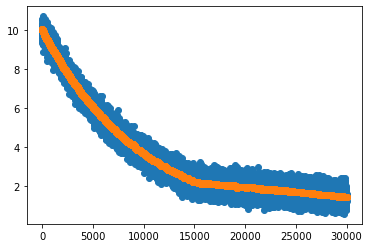

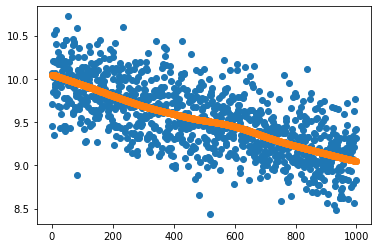

In [231]:
expo = create_exp(N = 15000, A = 10 , B = 0.0001)
lin = create_lin(N = 15000, a = -0.00005 , b = expo[-1]-0.01*expo[-1])

X, Y = concat_noise(C = [expo,lin], m = 0, s = 0.3)
Ysmooth = lowess(exog = X, endog = Y, frac = 0.01, delta = 0.001 * X.shape[0], return_sorted = False)

plt.scatter(X,Y)
plt.scatter(X,Ysmooth)
plt.show()

plt.scatter(X[0:1000],Y[0:1000])
plt.scatter(X[0:1000],Ysmooth[0:1000])
plt.show()

## linear RMSE

sample weight raw
 [1. 1. 1. ... 1. 1. 1.]
phase lin
sample weight arange 
 [   1    2    3 ... 4998 4999 5000]
sample weight squared 
 [              1              16              81 ... 624000599840016
 624500149980001 625000000000000]
sample weight weighted
 [1.0000000e+00 9.9920024e-01 9.9840096e-01 ... 1.2960000e-13 2.5600000e-14
 1.6000000e-15]
sample weight raw
 [1. 1. 1. ... 1. 1. 1.]
phase lin
sample weight arange 
 [   1    2    3 ... 5498 5499 5500]
sample weight squared 
 [              1              16              81 ... 913732225824016
 914397181478001 915062500000000]
sample weight weighted
 [1.00000000e+00 9.99272926e-01 9.98546248e-01 ... 8.85185438e-14
 1.74851445e-14 1.09282153e-15]
sample weight raw
 [1. 1. 1. ... 1. 1. 1.]
phase lin
sample weight arange 
 [   1    2    3 ... 5998 5999 6000]
sample weight squared 
 [               1               16               81 ... 1294272863808016
 1295136215976001 1296000000000000]
sample weight weighted
 [1.00000000e+00 9

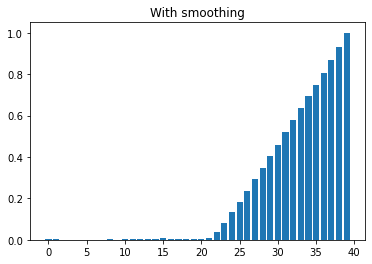

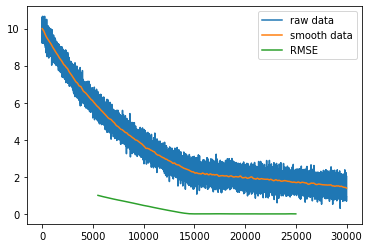

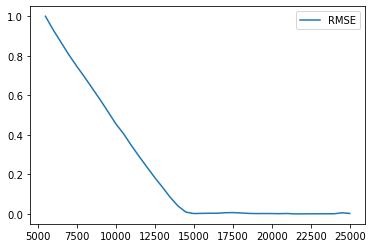

In [83]:
score,Xscore  = sliding_window_pred(X = X, y = Ysmooth, 
                            window = 5000, 
                            lag = 500)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('With smoothing')
plt.show()

# plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
# plt.title('With smoothing')
# plt.show()

plt.plot(X,Y, label = 'raw data')
plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(np.array(score)), label = 'RMSE') # amplified in order to have similar scale with raw signal
# plt.plot(Xscore[1:],np.diff(score), label = 'RMSE diff')
plt.legend()
plt.show()


plt.plot(Xscore,(np.array(score)), label = 'RMSE') # amplified in order to have similar scale with raw signal
# plt.plot(Xscore[1:],np.diff(score), label = 'RMSE diff')
plt.legend()
plt.show()

In [62]:
print(Xscore)
print(score)

[29500 29491 29482 ...    34    25    16]
[0.00480658 0.00462358 0.00443704 ... 0.997829   0.99891588 1.        ]


## Exponential RMSE

b is a bound parameters for A and B parameters of the exponential function 

this setting can deeply influence non linear regression

/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


FITTING WEIGHTED LINEAR REGRESSION
sample weight raw
 [1. 1. 1. ... 1. 1. 1.]
phase exp
sample weight squared 
 [2.56000000e-30 6.55360000e-28 1.67961600e-26 ... 9.96804476e-01
 9.98401120e-01 1.00000000e+00]
sample weight weighted
 [2.56000000e-30 6.55360000e-28 1.67961600e-26 ... 9.96804476e-01
 9.98401120e-01 1.00000000e+00]
FITTING WEIGHTED LINEAR REGRESSION
sample weight raw
 [1. 1. 1. ... 1. 1. 1.]
phase exp
sample weight squared 
 [1.19425889e-30 3.05730277e-28 7.83553260e-27 ... 9.97094609e-01
 9.98546380e-01 1.00000000e+00]
sample weight weighted
 [1.19425889e-30 3.05730277e-28 7.83553260e-27 ... 9.97094609e-01
 9.98546380e-01 1.00000000e+00]
FITTING WEIGHTED LINEAR REGRESSION
sample weight raw
 [1. 1. 1. ... 1. 1. 1.]
phase exp
sample weight squared 
 [5.95374181e-31 1.52415790e-28 3.90625000e-27 ... 9.97336442e-01
 9.98667444e-01 1.00000000e+00]
sample weight weighted
 [5.95374181e-31 1.52415790e-28 3.90625000e-27 ... 9.97336442e-01
 9.98667444e-01 1.00000000e+00]
FITTING WE

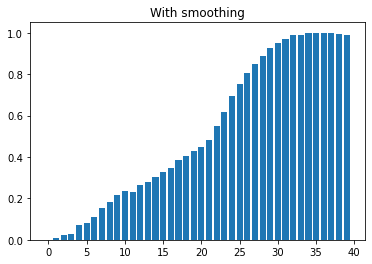

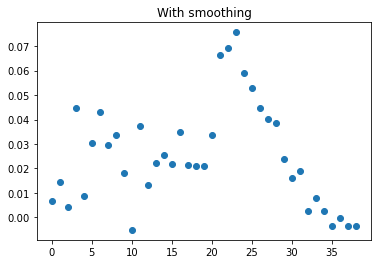

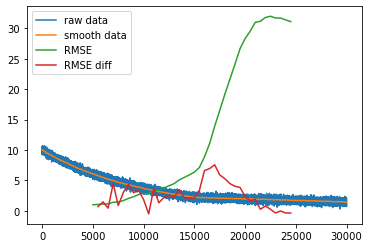

In [82]:
score,Xscore  = sliding_window_exp_pred(X = X, y = Ysmooth, 
                            window = 5000, 
                            lag = 500, b=([9,  0.00001], [11.,  0.001]), p =True)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('With smoothing')
plt.show()
plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.title('With smoothing')
plt.show()

plt.plot(X,Y, label = 'raw data')
plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(1+np.array(score))**5, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*100, label = 'RMSE diff')
plt.legend()
plt.show()

## Both linear and exp RMSE

In [ ]:
def sliding_window_pred(X, y, window, lag):
    Xend = np.shape(X)[0]
    Xmax = np.shape(X)[0]-lag-1
    start = np.arange(window, Xend-window, lag)
   
    mean_start = X[[int(Xend-s) for s in start]]
    # print('lin idx', [int(np.floor((Xend-s+ Xend)/2)) for s in start])
    # print('mean start LIN',mean_start)
    # input()
    score = [fit_and_pred(X[Xend-s:Xend], y[Xend-s:Xend]) 
            for s in start]
    score = min_max(score)
    
    return score, mean_start


def sliding_window_exp_pred(X, y, window, lag, b=([9,  0.00001], [11.,  0.001]), p = False):
    Xend = np.shape(X)[0]
    Xmax = np.shape(X)[0]-lag-1
    start = np.arange(window, Xend-window, lag)
    mean_start = X[start ]
    
    reg = _detect_b( X[lag:lag+(window*4)], y[lag:lag+(window*4)])
    A, B = reg 
    bound = ([A-0.1*A,B/10],[A+0.1*A, B*10])
    
    score = [fit_and_pred_exp(X[0:s], y[0:s], b=b, p = p) 
            for s in start if s<=(Xend-window)] 
    
#     score = (score- np.mean(score)) / np.std(score)
    score = min_max(score)  
    return score, mean_start

In [97]:
X1 = np.array(X).reshape(-1)[0:10]

In [99]:
 X1[:np.maximum(int(0.5*X1.size),5)]

array([0, 1, 2, 3, 4])

In [156]:
X1[int(0.85*X1.size)::]

array([8, 9])

In [237]:
def fit_and_pred(X, y):
    Xarr = np.array(X).reshape(-1,1)
    yarr = np.array(y).reshape(-1,1)
    
    sample_weight = np.ones(yarr.size)
    yarr = np.log(yarr)

#     yarr[:np.maximum(int(0.15*yarr.size),5)]=np.square(yarr[:np.maximum(int(0.15*yarr.size),5)]+1)

#     print('sample weight raw\n', sample_weight)
#     print('phase lin')
#     sample_weight = np.arange(1,yarr.size+1) 
#     print('sample weight arange \n', sample_weight)
#     i=0
#     while i < 2:        
#         sample_weight = np.square(sample_weight)
#         i+=1
#     print('sample weight squared \n', sample_weight)

#     sample_weight = sample_weight / sample_weight.max()
#     sample_weight = np.flip(sample_weight)
#     print('sample weight weighted\n', sample_weight) 
    
    reg = LinearRegression().fit(Xarr, yarr, sample_weight)
    pred = reg.predict(Xarr)
    rmse = RMSE(pred, yarr)
    return rmse

def fit_and_pred_exp(X, y, b, p=False):
    Xarr = np.array(X).reshape(-1,1)
    yarr = np.array(y).reshape(-1,1)
    
#     print('FITTING WEIGHTED LINEAR REGRESSION')
    sample_weight = np.ones(yarr.size)
    yarr = np.log(yarr)
    
#     yarr[np.maximum(int(0.85*yarr.size),5)::]=np.square(yarr[np.maximum(int(0.85*yarr.size),5)::])

#     print('sample weight raw\n', sample_weight)
#     print('phase exp')
#     sample_weight = np.arange(1,yarr.size+1) 
#     sample_weight = np.square(sample_weight)                   
#     sample_weight = sample_weight / sample_weight.max()
#     i=0
#     while i < 2:        
#         sample_weight = np.square(sample_weight)
#         i+=1
#     print('sample weight squared \n', sample_weight)
# #     sample_weight = np.flip(sample_weight)
#     print('sample weight weighted\n', sample_weight)

    reg = LinearRegression().fit(Xarr, yarr, sample_weight)    
    pred = reg.predict(Xarr)
    rmse = RMSE(pred, yarr)
    return rmse


In [222]:
def dcross(Yl, Ye):
    idx = np.argwhere(np.diff(np.sign(Yl - Ye))).flatten() 
    return idx

def detect_crossing(X, Y, Yexp, Ylin, Xl, Xe):
    Ylin=np.array(Ylin)
    Yexp=np.array(Yexp)
    Xl=np.array(Xl)  
    Xe=np.array(Xe) 
    idx = dcross(np.flip(Ylin), Yexp)
    Xidx=Xe[idx] 
    idx_int = [[i, i+1] for i in idx]
    Xidx_int = [[Xe[i], Xe[i+1] ]for i in idx]
    Yidx=Yexp[idx]
#     Yidx=np.flip(Ylin)[idx]
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('time (min)')
    ax1.set_ylabel('sample', color=color)
    ax1.plot(X, Y, color=color, linestyle='-', marker='o', label = 'data')
    color = 'tab:red'
#     ax1.plot(Xselected, Ysmooth, color=color, lw=2, linestyle='-', label = 'smooth')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'
    ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
    ax2.plot(Xl, Ylin, color=color, marker='o', label = 'RMSE lin')
    ax2.tick_params(axis='y', labelcolor=color)
    color = 'tab:orange'
    ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
    ax2.plot(Xe, Yexp, color=color, marker='o', label = 'RMSE exp')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend()
#     for i in np.arange(0,len(idx)):
#         ax2.hlines(Yidx[i], Xidx_int[i][0], Xidx_int[i][1], lw=4, color = 'black')
    plt.plot(Xidx, Yidx, 'ro')
    fig.tight_layout()
    plt.show()
    
    for i in np.arange(0,len(idx)):
        print('detected changes between times : {}'.format(Xidx[i]))

/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


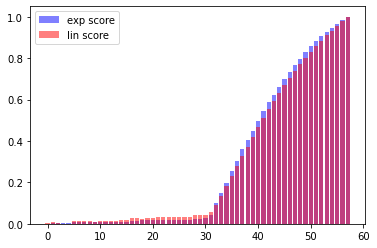

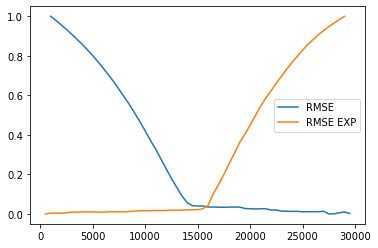

In [238]:
wind = 500
lag = 500

score,Xscore  = sliding_window_pred(X = X, y = Ysmooth, 
                            window = wind, 
                            lag = lag)

score_exp,Xscore_exp  = sliding_window_exp_pred(X = X, y = Ysmooth, 
                            window = wind, 
                            lag = lag, b=([9,  0.00001], [11.,  0.001]), p = False)


plt.bar(np.arange(0,len(score_exp)),score_exp, label = 'exp score', fc=(0, 0, 1, 0.5))
plt.bar(np.arange(0,len(score)),score, label = 'lin score', fc=(1, 0, 0, 0.5))
plt.legend()
plt.show()

# plt.plot(X,Y, label = 'raw data')
# plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(np.array(score)), label = 'RMSE') # amplified in order to have similar scale with raw signal
# plt.plot(Xscore[1:],np.diff(score), label = 'RMSE diff')

plt.plot(Xscore_exp,(np.array(score_exp)), label = 'RMSE EXP') # amplified in order to have similar scale with raw signal
# plt.plot(Xscore_exp[1:],np.diff(score_exp), label = 'RMSE diff EXP')
plt.legend()
plt.show()

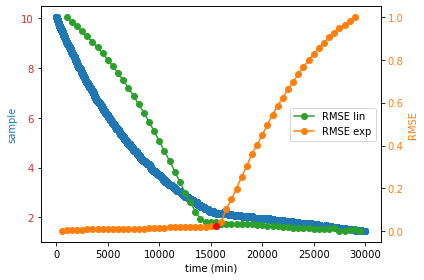

detected changes between times : 15500


In [239]:
# both log
detect_crossing(X, Ysmooth, Yexp=score_exp,
                Ylin=score, Xl=Xscore, Xe=Xscore_exp)

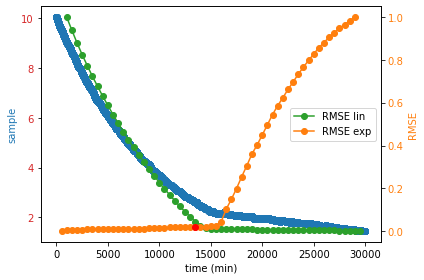

detected changes between times : 13500


In [236]:
# only exp log
detect_crossing(X, Ysmooth, Yexp=score_exp,
                Ylin=score, Xl=Xscore, Xe=Xscore_exp)

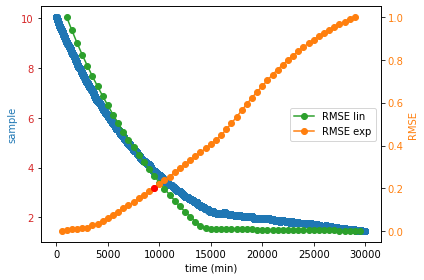

detected changes between times : 9500


In [233]:
# no log
detect_crossing(X, Ysmooth, Yexp=score_exp,
                Ylin=score, Xl=Xscore, Xe=Xscore_exp)

This is super nice :)

# Real data

['LituBD5_mass', 'LituLD2_mass', 'LituBL2t_mass', 'LituLL21_mass']


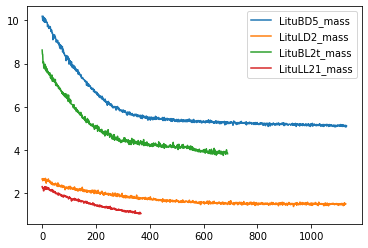

In [229]:
df = pd.read_csv('/home/xavier/Documents/development/DetectEvent/data/time series_dehydration.csv', sep = ",")
# df = pd.read_csv('/home/xavier/Documents/development/DetectEvent/data/auto_gmin_testdataset.csv', sep = ",", skiprows=1)


df.head()
col = [c for c in df.columns if c != 'time_min']
print(col)
df[col].plot()

In [228]:
#extracted from third iteration and then refitted can be automatized later

Bound = [([10.041-2,0.0000503],[10.041+2,0.00503]), #a=5.504, b=0.000016
         ([2.508-2,0.0000262],[2.508+2,0.00262]), #  a=2.000, b=0.000072
         ([8.037-2,0.0000618],[8.037+2,0.00618]), #a=5.119, b=0.000107
         ([2.314-2,0.0000681],[2.314+2,0.00681])] #a=2.000, b=0.000436

i = 0
for c in col:
    
    print('test for {} -------------------------------'.format(c))
    df2 = df[['time_min', c]].dropna(subset = [c])
    Ysmooth = lowess(exog = df2['time_min'].values, endog = df2[c].values, frac = 0.1, delta = 0.1 * df2['time_min'].shape[0], return_sorted = False)
    
    
    score,Xscore  = sliding_window_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50))

    score_exp,Xscore_exp  = sliding_window_exp_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50), b= Bound[i], p = True)
    i+=1
    plt.bar(np.arange(0,len(score_exp)),score_exp, label = 'exp score', fc=(0, 0, 1, 0.5))
    plt.bar(np.arange(0,len(score)),score, label = 'lin score', fc=(1, 0, 0, 0.5))
    plt.legend()
    plt.show()

    plt.plot(df2['time_min'].values,df2[c].values, label = 'raw data')
    plt.plot(df2['time_min'].values, Ysmooth, label = 'smooth data')
    plt.plot(Xscore,np.array(score)*100, label = 'RMSE') # amplified in order to have similar scale with raw signal
#     plt.plot(Xscore[1:],np.diff(score), label = 'RMSE diff')

    plt.plot(Xscore_exp,np.array(score_exp)*100, label = 'RMSE EXP') # amplified in order to have similar scale with raw signal
#     plt.plot(Xscore_exp[1:],np.diff(score_exp), label = 'RMSE diff EXP')
    plt.legend()
    plt.show()

test for campaign -------------------------------


KeyError: "['time_min'] not in index"


test for LituBD5_mass -------------------------------


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


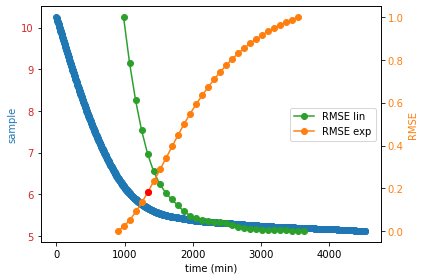

detected changes between times : 1344

test for LituLD2_mass -------------------------------


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


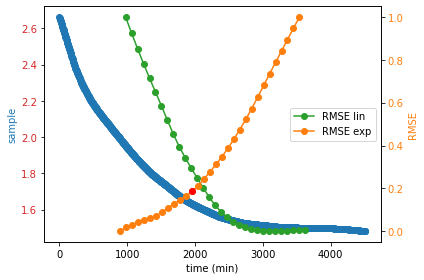

detected changes between times : 1956

test for LituBL2t_mass -------------------------------


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


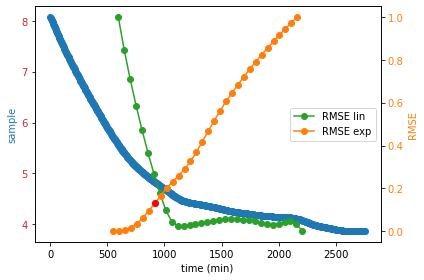

detected changes between times : 916

test for LituLL21_mass -------------------------------


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


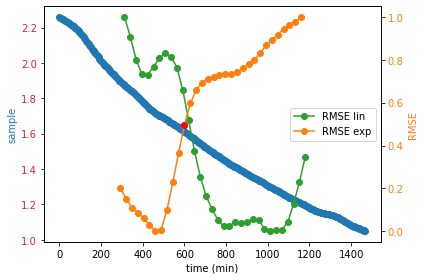

detected changes between times : 600


In [223]:
#extracted from third iteration and then refitted can be automatized later

Bound = [([10.041-2,0.0000503],[10.041+2,0.00503]), #a=5.504, b=0.000016
         ([2.508-2,0.0000262],[2.508+2,0.00262]), #  a=2.000, b=0.000072
         ([8.037-2,0.0000618],[8.037+2,0.00618]), #a=5.119, b=0.000107
         ([2.314-2,0.0000681],[2.314+2,0.00681])] #a=2.000, b=0.000436

i = 0
for c in col:
    
    print('\ntest for {} -------------------------------'.format(c))
    df2 = df[['time_min', c]].dropna(subset = [c])
    Ysmooth = lowess(exog = df2['time_min'].values, endog = df2[c].values, frac = 0.1, delta = 0.1 * df2['time_min'].shape[0], return_sorted = False)
    
    
    score,Xscore  = sliding_window_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50))

    score_exp,Xscore_exp  = sliding_window_exp_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50), b= Bound[i], p = False)
    i+=1
    detect_crossing(df2['time_min'].values, Ysmooth, Yexp=score_exp,
                    Ylin=score, Xl=Xscore, Xe=Xscore_exp)
